# 라이브러리 불러오기

In [350]:
from numpy import asarray
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas_datareader.data as pdr
import numpy as np
from xgboost import plot_importance, plot_tree
from numpy import asarray
from xgboost import XGBRegressor
from math import sqrt
from matplotlib import pyplot
from datetime import date
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline

import warnings
import plotly.graph_objects as go
import chart_studio.plotly as py
import plotly.offline as pyo
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

warnings.filterwarnings(action='ignore')

In [351]:
## 공휴일 데이터 불러오기
holidays = pd.read_csv('data/holidays.csv', encoding = 'euc_kr', index_col = 0)

holidays['date'] = pd.to_datetime(holidays['date']).dt.date
holidays = holidays.append({'date' : date(2019,5,2), 'name':'연휴'}, ignore_index = True)
holidays = holidays.append({'date' : date(2019,5,3), 'name':'연휴'}, ignore_index = True)
holidays = holidays.append({'date' : date(2020,5,7), 'name':'연휴'}, ignore_index = True)
holidays = holidays.append({'date' : date(2020,5,4), 'name':'연휴'}, ignore_index = True)
holidays = holidays.append({'date' : date(2020,5,1), 'name':'연휴'}, ignore_index = True)
holidays = holidays.append({'date' : date(2019,12,31), 'name':'연말'}, ignore_index = True)
holidays = holidays.append({'date' : date(2020,12,31), 'name':'연말'}, ignore_index = True)

- 공휴일의 특징 파악
- 평일의 특징 파악
- 주말의 특징 파악
- train 데이터에서 각 종속변수 별로 주말이나 공휴일에 어떻게 변하는지 확인

# 데이터 불러오기

In [352]:
## 데이터 불러오기
train = pd.read_csv("data/train.csv", encoding = 'euc-kr')
train['DateTime'] = pd.to_datetime(train['DateTime'])
train['date'] = train.DateTime.dt.date

new_train= pd.read_csv("data/2차_train.csv", encoding = 'euc-kr')
new_train['DateTime'] = pd.to_datetime(new_train['DateTime'])
new_train['date'] = new_train.DateTime.dt.date

## 시간 합산
train = pd.DataFrame(train.groupby('date').sum().reset_index())
new_train = pd.DataFrame(new_train.groupby('date').sum().reset_index())

In [353]:
## 1차 train과 2차 train 합치기
train = pd.concat([train, new_train]).reset_index(drop = True)

# train의 date도 같은 형식으로 뽑기
train['date'] = pd.to_datetime(train['date']).dt.date

train.tail()

,date,사용자,세션,신규방문자,페이지뷰
817,2020-12-04,3189,3068,743,75730
818,2020-12-05,2055,2019,497,47638
819,2020-12-06,2119,2077,460,46914
820,2020-12-07,2979,2988,753,77443
821,2020-12-08,3033,2990,772,68857


In [354]:
submission = pd.read_csv('data/submission.csv', encoding = 'euc-kr')
submission.DateTime = pd.to_datetime(submission.DateTime).dt.date
submission = submission[submission.DateTime>date(2020,12,8)].reset_index(drop = True)

In [355]:
login_info = pd.read_csv('data/info_login.csv', index_col=0)
competition_info = pd.read_csv('data/info_competition.csv', index_col=0, encoding='cp949')
user_info = pd.read_csv('data/info_user.csv', index_col=0)
submission_info = pd.read_csv('data/info_submission.csv', index_col=0)

## 2차 대회 정보 데이터
new_competition_info = pd.read_csv('data/new_competition_info.csv', index_col=0, encoding='cp949').dropna(how = 'all')

In [356]:
# 공휴일 train
train_holidays = train[train['date'].isin(holidays['date'])]

# 일반 train
train_not_holidays = train[~train['date'].isin(holidays['date'])]

# < 주말 뽑기 >

In [357]:
from datetime import timedelta, date
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)
        
# train 시작하는 날
start_dt = date(2018,9,9)
# train 끝나는 날 -> new_train을 포함하면서 end_dt를 바꿈
end_dt = date(2020,12,8)

# sub 시작하는 날 -> new_train을 포함하면서 end_dt를 바꿈
start_sub = date(2020,12,9)
# sub 끝나는 날
end_sub = date(2021,1,8)

# 토요일과 일요일
weekdays = [5,6]

# train 정보 저장 : test 데이터로 검정할 때 확인
t_weekday = []
t_weekend = []
for dt in daterange(start_dt, end_dt):
    if dt.weekday() not in weekdays:               
        t_weekday.append(dt.strftime("%Y-%m-%d"))
    else:
        t_weekend.append(dt.strftime("%Y-%m-%d"))


# 제출할 때 적용하기 위함
sub_weekday = []
sub_weekend = []
for dt in daterange(start_sub, end_sub):
    if dt.weekday() not in weekdays:               
        sub_weekday.append(dt.strftime("%Y-%m-%d"))
    else:
        sub_weekend.append(dt.strftime("%Y-%m-%d"))

In [358]:
# train의 주말 연,월,일만 뽑기
train_5day = pd.to_datetime(np.array(t_weekday)).date
train_2day = pd.to_datetime(np.array(t_weekend)).date

# train의 주말 연,월,일만 뽑기
sub_5day = pd.to_datetime(np.array(sub_weekday)).date
sub_2day = pd.to_datetime(np.array(sub_weekend)).date

# train의 date도 같은 형식으로 뽑기
submission['DateTime'] = pd.to_datetime(submission['DateTime']).dt.date

# 함수

In [359]:
## train의 주말 연,월,일만 뽑기
train_5day = pd.to_datetime(np.array(t_weekday)).date
train_2day = pd.to_datetime(np.array(t_weekend)).date
holiday_date = pd.to_datetime(np.array(holidays['date'])).date


################ 공휴일에 원하는 가중치를 주는 함수 #################
holiday_date = pd.to_datetime(np.array(holidays['date'])).date

def holidays_data(data, date, col, weight):
    data[date] = pd.to_datetime(data[date])
    
    # 분할
    holidays_data = data[data[date].isin(holiday_date)][[date,col]]
    not_holidays_data = data[~data[date].isin(holiday_date)][[date, col]]
    # 공휴일 가중치
    holidays_data[col] = holidays_data[col]* weight
    
    df = pd.concat([holidays_data, not_holidays_data]).sort_values(by = date)
    df = df.set_index(date)
    
    return df


################ 주말 및 공휴일과 평일을 분리하는 함수 ###################
    # train
train_holidays['date'] = pd.to_datetime(train_holidays['date'])

# train과 sub의 휴일 분리
t_holidays = holiday_date[holiday_date <= date(2020, 12, 8)]
sub_holidays = holiday_date[holiday_date > date(2020, 12, 8)]
all_train_rest = np.unique(np.sort(np.append(np.array(train_holidays['date'].dt.date), train_2day)))
    # sub
all_sub_rest = np.sort(np.append(sub_holidays, sub_2day))

def data_rest_distribution(data, date, train_or_sub_date):
    data[date] = pd.to_datetime(data[date]).dt.date
    
    # 분할
    data_rest = data[data[date].isin(train_or_sub_date)]# [['date',col]]
    data_not_rest = data[~data[date].isin(train_or_sub_date)]# [['date',col]]
    
    return data_rest, data_not_rest

# 대회 개수 변수 추가

In [360]:
competition = new_competition_info

# competition

# 각 날짜별 진행되고 있는 대회 개수
# competition 데이터셋의 모든 기간을 포함.

def date_cpt_count(competition):
    from datetime import date, timedelta

    # datatype: datetime으로 변경
    competition['period_start'] =  pd.to_datetime(competition.period_start)
    competition['period_end'] =  pd.to_datetime(competition.period_end)
    # date로 변경
    competition['period_start'] = competition.period_start.dt.date
    competition['period_end'] = competition.period_end.dt.date

    # 모든 대회 기간을 포함하는 datelist 생성. 897개
    start = competition['period_start'].min()
    end = competition['period_end'].max()

    datelist = []
    for i in range((end-start).days +1):
        datelist.append(start+timedelta(days=i))

    # 각 날짜에 대회가 몇개 열렸는지 매칭.
    cpt_cnt = [0 for i in range(len(datelist))] 

    for i in range(len(competition)):
        s = competition.iloc[i]['period_start']
        e = competition.iloc[i]['period_end']
      
        t = 0
        for d in datelist:
            if d >= s and d<=e:
                cpt_cnt[t]+=1
            t+=1

    date_cpt_cnt = pd.DataFrame({'date':datelist
                                ,'count': cpt_cnt})
    date_cpt_cnt.head()

    return date_cpt_cnt

competition = date_cpt_count(competition)
competition.tail(5)

,date,count
900,2021-01-30,1
901,2021-01-31,1
902,2021-02-01,1
903,2021-02-02,1
904,2021-02-03,1


In [361]:
competition['date'] = pd.to_datetime(competition['date'])
competition['date'] = competition['date'].dt.date
competition = competition[(competition['date'] >= date(2018,9,9))&(competition['date']<=date(2021, 1, 8))].reset_index(drop = True)

## 대회 개수 변수  추가
train['competition_counts'] = pd.Series(competition[(competition['date']>=date(2018,9,9)) & (competition['date']<=date(2020, 12, 8))].reset_index(drop = True)['count'])
submission['competition_counts'] = pd.Series(competition[(competition['date']>=date(2020,12,9)) & (competition['date']<=date(2021, 1, 8))].reset_index(drop = True)['count'])

--------------

# XGB 적용하기

In [362]:
## 여러 정보를 바탕으로 XGB에는 19년 5월 부터 데이터 사용
train = train[(pd.to_datetime(train['date'])>='2019-05-01') & (pd.to_datetime(train['date'])<='2020-12-08')]

In [363]:
# time_series로 만들기
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # 입력 sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # 출력 sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# 데이터 분할
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state = 40)
    model.fit(trainX, trainy)
    yhat = model.predict(asarray([testX]))
    return yhat[0]
 
    
def root_mean_squared_error(y, t):
    return sqrt(((y-t)**2).mean(axis=None))
    
    
# 데이터 분할하여 추세 예측
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = root_mean_squared_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

In [364]:
## 데이터 분할
train_rest, train_not_rest = data_rest_distribution(train, 'date', all_train_rest)
sub_rest, sub_not_rest = data_rest_distribution(submission, 'DateTime', all_sub_rest)

train_rest = train_rest.set_index('date')
train_not_rest = train_not_rest.set_index('date')
sub_rest = sub_rest.set_index('DateTime')
sub_not_rest = sub_not_rest.set_index('DateTime')

print(train_rest.shape)
print(train_not_rest.shape)
print(sub_rest.shape)
print(sub_not_rest.shape)

(195, 5)
(393, 5)
(11, 5)
(20, 5)


In [365]:
values = list(train_rest.iloc[:,3].values)
data = series_to_supervised(values, n_in=90)
data

# walk_forward_validation의 n_test를 100으로 두면 마지막 100개를 검증셋으로 활용함
rmse, y, yhat = walk_forward_validation(data, 10)

>expected=57386.0, predicted=41700.9
>expected=50486.0, predicted=38976.0


KeyboardInterrupt: 

RMSE: 9956.468


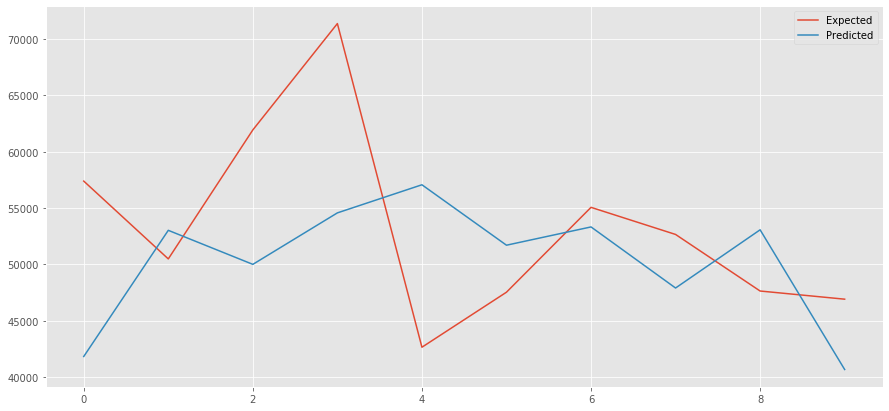

In [305]:
print('RMSE: %.3f' % rmse)
# plot expected vs preducted
plt.figure(figsize = (15,7))
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

- n_in값을 크게 하면 모델이 학습하는 데이터의 양이 커져서 보다 더 잘 학습함

-----------------------

# 확인하기(과정 skip)
- xgb 스태킹 최고기록은 평일과 휴일로 1차 나눈 결과가 아니라 
- 평일과 휴일을 나눈 뒤 대회 개수에 따라서 2차 나눔을 한 결과이다.

--------------------------

# 대회 개수에 따른 분류 확인

# 휴일

In [366]:
## 대회 수에 따른 관측치 개수 확인
print('### train 파일 ###')
print(train.competition_counts.value_counts())
print()
print('### submission 파일 ###')
print(submission.competition_counts.value_counts())


### train 파일 ###
3    228
2    118
4     94
1     85
7     18
5     15
0     14
6     13
9      3
Name: competition_counts, dtype: int64

### submission 파일 ###
7    11
5     7
6     5
2     4
3     4
Name: competition_counts, dtype: int64


## 상자그림을 통한 Y 분포 확인

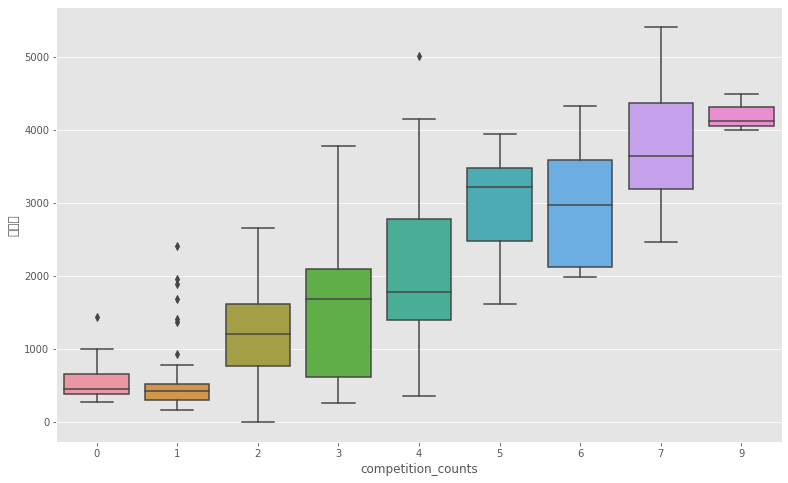

In [367]:
# 휴일과 평일을 나누지 않은 상태(train)의 대회 수에 따른 분포 확인
plt.figure(figsize = (13,8))
sns.boxplot(x = 'competition_counts',
           y = '사용자',
           data = train)

## 1. 사용자

In [368]:
train_rest.groupby('competition_counts')['사용자'].mean()

competition_counts
0     352.750000
1     361.620690
2     936.150000
3    1222.152941
4    1379.240000
5    1718.000000
6    2151.666667
7    2592.750000
Name: 사용자, dtype: float64

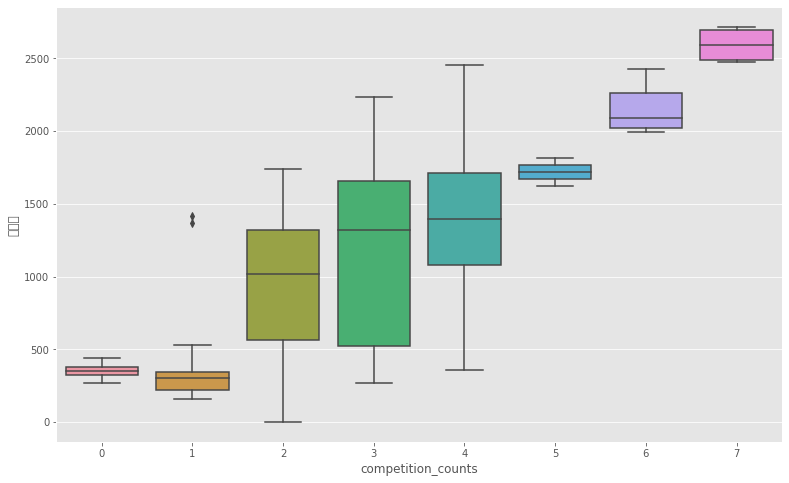

In [369]:
plt.figure(figsize = (13,8))
sns.boxplot(x = 'competition_counts',
           y = '사용자',
           data = train_rest)

- [0,1], [2,3,4], [5,6,7]

- [0,1,2], [3,4,5,6,7]

## 2. 세션

In [370]:
print(train_rest.groupby('competition_counts')['세션'].mean())
print(train_rest.competition_counts.value_counts())

competition_counts
0     373.000000
1     371.344828
2     937.275000
3    1202.282353
4    1345.640000
5    1690.500000
6    2108.333333
7    2525.000000
Name: 세션, dtype: float64
3    85
2    40
1    29
4    25
6     6
0     4
7     4
5     2
Name: competition_counts, dtype: int64


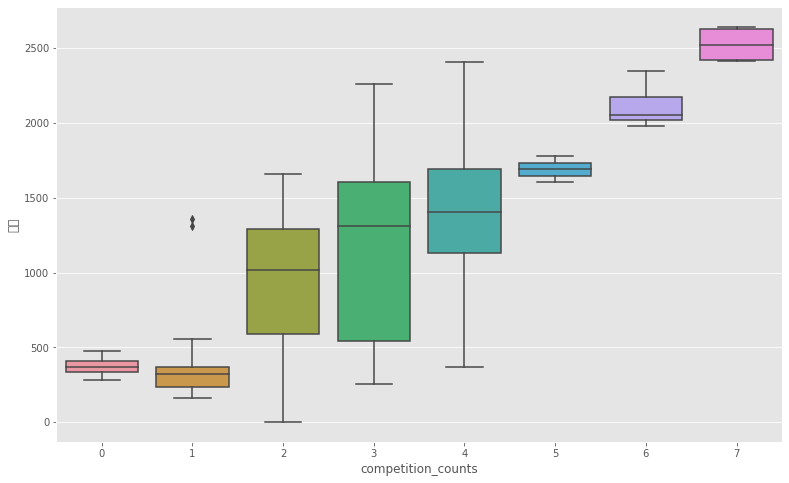

In [371]:
plt.figure(figsize = (13,8))
sns.boxplot(x = 'competition_counts',
           y = '세션',
           data = train_rest)

- [0,1], [2,3,4], [5,6,7]

- [0,1,2], [3,4,5,6,7]

## 3. 신규방문자

In [372]:
train_rest.groupby('competition_counts')['신규방문자'].mean()

competition_counts
0    135.250000
1    107.448276
2    215.800000
3    257.341176
4    283.520000
5    370.500000
6    479.000000
7    510.000000
Name: 신규방문자, dtype: float64

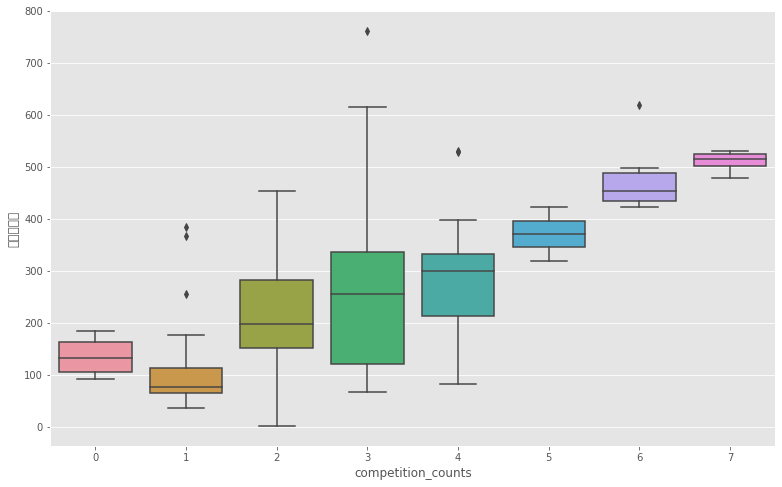

In [373]:
plt.figure(figsize = (13,8))
sns.boxplot(x = 'competition_counts',
           y = '신규방문자',
           data = train_rest)

- [0,1], [2,3,4], [5,6,7]

## 4. 페이지뷰

In [374]:
train_rest.groupby('competition_counts')['페이지뷰'].mean()

competition_counts
0     3918.000000
1     6168.517241
2    21206.025000
3    28225.070588
4    34118.200000
5    38133.000000
6    50257.833333
7    60288.750000
Name: 페이지뷰, dtype: float64

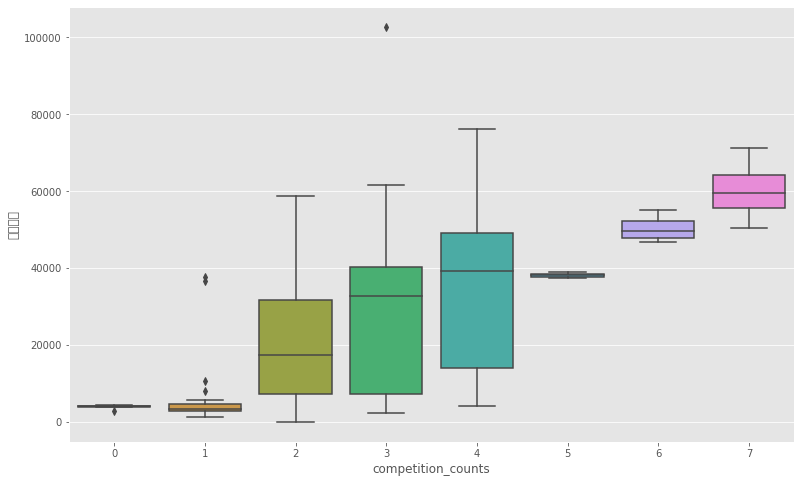

In [375]:
plt.figure(figsize = (13,8))
sns.boxplot(x = 'competition_counts',
           y = '페이지뷰',
           data = train_rest)

- [0,1], [2,3,4, 5], [6,7]
- 3개로 분할 했을때의 범주 => 5,6,7의 데이터가 너무나 부족

----------------------------

# 주중

## 1. 사용자

In [376]:
train_not_rest.groupby('competition_counts')['사용자'].mean()

competition_counts
0     675.400000
1     584.642857
2    1374.371795
3    1769.132867
4    2327.608696
5    3141.769231
6    3569.285714
7    4074.928571
9    4206.666667
Name: 사용자, dtype: float64

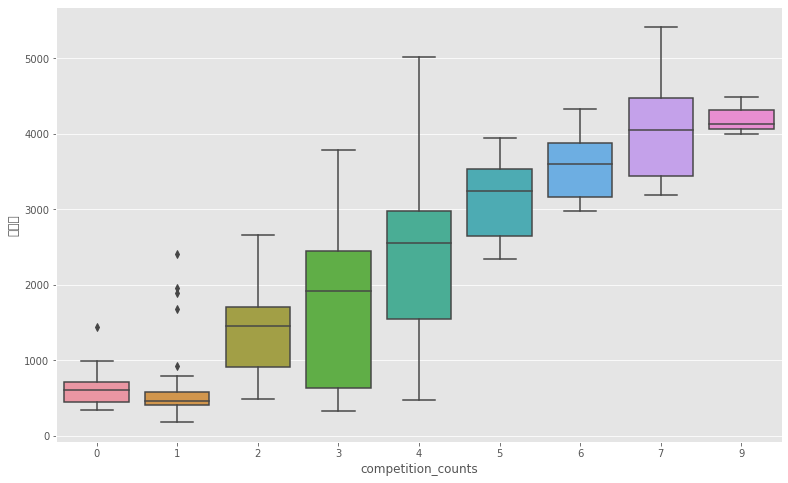

In [377]:
plt.figure(figsize = (13,8))
sns.boxplot(x = 'competition_counts',
           y = '사용자',
           data = train_not_rest)

- [0,1], [2,3,4], [7]

## 2. 세션

In [378]:
train_not_rest.groupby('competition_counts')['세션'].mean()

competition_counts
0     721.900000
1     603.321429
2    1376.089744
3    1743.895105
4    2298.811594
5    3086.692308
6    3512.000000
7    3979.285714
9    4105.000000
Name: 세션, dtype: float64

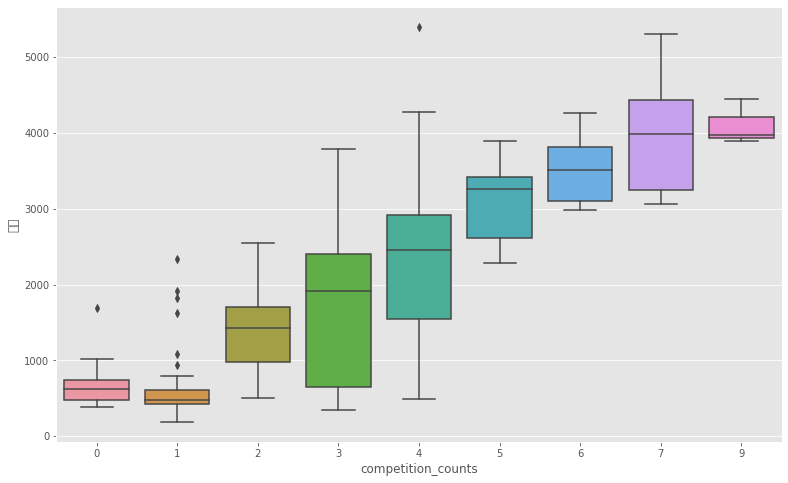

In [379]:
plt.figure(figsize = (13,8))
sns.boxplot(x = 'competition_counts',
           y = '세션',
           data = train_not_rest)

- [0,1], [2,3,4,5], [7]

## 3. 신규방문자

In [380]:
train_not_rest.groupby('competition_counts')['신규방문자'].mean()

competition_counts
0    272.500000
1    179.196429
2    338.858974
3    418.013986
4    558.188406
5    774.769231
6    905.000000
7    985.428571
9    900.666667
Name: 신규방문자, dtype: float64

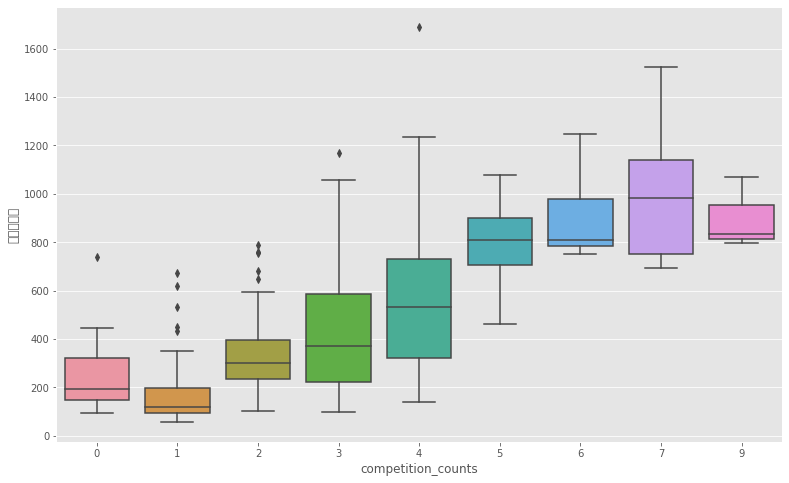

In [381]:
plt.figure(figsize = (13,8))
sns.boxplot(x = 'competition_counts',
           y = '신규방문자',
           data = train_not_rest)

- [0,1,2], [3,4,5], [7]

## 4. 페이지뷰

In [382]:
train_not_rest.groupby('competition_counts')['페이지뷰'].mean()

competition_counts
0      8613.000000
1     10459.750000
2     30244.256410
3     40256.811189
4     59579.159420
5     79547.230769
6     86728.142857
7    102234.571429
9    103550.666667
Name: 페이지뷰, dtype: float64

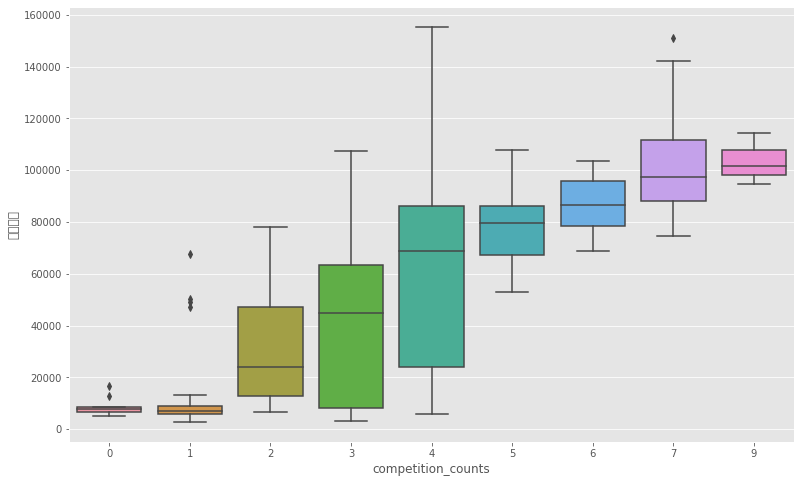

In [383]:
plt.figure(figsize = (13,8))
sns.boxplot(x = 'competition_counts',
           y = '페이지뷰',
           data = train_not_rest)

- [0,1], [2,3,4,5], [7]

--------------------

# 평일과 휴일 분리 + 대회 개수에 따른 분리 XGB 적용
* 휴일의 경우 [0,1,2], [3,4,5,6,7]
* 주중의  경우 
	  *[0,1,2], [3,4,5,6,7]
	  *[0,1,2,3], [4,5,6,7]

In [384]:
submission.competition_counts.value_counts()

7    11
5     7
6     5
2     4
3     4
Name: competition_counts, dtype: int64

In [385]:
## 인덱스 제거
train_not_rest.reset_index(drop=False, inplace = True)
train_rest.reset_index(drop=False, inplace = True)

sub_rest.reset_index(drop=False, inplace = True)
sub_not_rest.reset_index(drop=False, inplace = True)

In [386]:
## 사용자 분리 : 휴일
t_user_rest_012 = train_rest[train_rest.competition_counts.isin([0,1,2])][['date','사용자']].reset_index(drop=True)
t_user_rest_34567 = train_rest[train_rest.competition_counts.isin([3,4,5,6,7])][['date','사용자']].reset_index(drop=True)
## 사용자 분리 : 평일
t_user_not_rest_012 = train_not_rest[train_not_rest.competition_counts.isin([0,1,2])][['date','사용자']].reset_index(drop=True)
t_user_not_rest_34567 = train_not_rest[train_not_rest.competition_counts.isin([3,4,5,6,7,9])][['date','사용자']].reset_index(drop=True)


## 세션 분리 : 휴일
t_sess_rest_012 = train_rest[train_rest.competition_counts.isin([0,1,2])][['date','세션']].reset_index(drop=True)
t_sess_rest_34567 = train_rest[train_rest.competition_counts.isin([3,4,5,6,7])][['date','세션']].reset_index(drop=True)
## 세션 분리 : 평일
t_sess_not_rest_012 = train_not_rest[train_not_rest.competition_counts.isin([0,1,2])][['date','세션']].reset_index(drop=True)
t_sess_not_rest_34567 = train_not_rest[train_not_rest.competition_counts.isin([3,4,5,6,7,9])][['date','세션']].reset_index(drop=True)


## 신규방문자 분리 : 휴일
t_new_rest_012 = train_rest[train_rest.competition_counts.isin([0,1,2])][['date','신규방문자']].reset_index(drop=True)
t_new_rest_34567 = train_rest[train_rest.competition_counts.isin([3,4,5,6,7])][['date','신규방문자']].reset_index(drop=True)
## 신규방문자 분리 : 평일
t_new_not_rest_012 = train_not_rest[train_not_rest.competition_counts.isin([0,1,2])][['date','신규방문자']].reset_index(drop=True)
t_new_not_rest_34567 = train_not_rest[train_not_rest.competition_counts.isin([3,4,5,6,7,9])][['date','신규방문자']].reset_index(drop=True)


## 페이지뷰 분리 : 휴일
t_page_rest_012 = train_rest[train_rest.competition_counts.isin([0,1,2])][['date','페이지뷰']].reset_index(drop=True)
t_page_rest_34567 = train_rest[train_rest.competition_counts.isin([3,4,5,6,7])][['date','페이지뷰']].reset_index(drop=True)
## 페이지뷰 분리 : 평일
t_page_not_rest_012 = train_not_rest[train_not_rest.competition_counts.isin([0,1,2])][['date','페이지뷰']].reset_index(drop=True)
t_page_not_rest_34567 = train_not_rest[train_not_rest.competition_counts.isin([3,4,5,6,7,9])][['date','페이지뷰']].reset_index(drop=True)

In [387]:
########################################################################################################################
#################################################### sub 분리 ##########################################################
########################################################################################################################
## 사용자 분리 : 휴일
s_user_rest_012 = sub_rest[sub_rest.competition_counts.isin([0,1,2])][['DateTime','사용자']].reset_index(drop=True)
s_user_rest_34567 = sub_rest[sub_rest.competition_counts.isin([3,4,5,6,7])][['DateTime','사용자']].reset_index(drop=True)
## 사용자 분리 : 평일
s_user_not_rest_012 = sub_not_rest[sub_not_rest.competition_counts.isin([0,1,2])][['DateTime','사용자']].reset_index(drop=True)
s_user_not_rest_34567 = sub_not_rest[sub_not_rest.competition_counts.isin([3,4,5,6,7,9])][['DateTime','사용자']].reset_index(drop=True)


## 세션 분리 : 휴일
s_sess_rest_012 = sub_rest[sub_rest.competition_counts.isin([0,1,2])][['DateTime','세션']].reset_index(drop=True)
s_sess_rest_34567= sub_rest[sub_rest.competition_counts.isin([3,4,5,6,7,9])][['DateTime','세션']].reset_index(drop=True)
## 세션 분리 : 평일
s_sess_not_rest_012 = sub_not_rest[sub_not_rest.competition_counts.isin([0,1,2])][['DateTime','세션']].reset_index(drop=True)
s_sess_not_rest_34567 = sub_not_rest[sub_not_rest.competition_counts.isin([3,4,5,6,7,9])][['DateTime','세션']].reset_index(drop=True)


## 신규방문자 분리 : 휴일
s_new_rest_012 = sub_rest[sub_rest.competition_counts.isin([0,1,2])][['DateTime','신규방문자']].reset_index(drop=True)
s_new_rest_34567 = sub_rest[sub_rest.competition_counts.isin([3,4,5,6,7])][['DateTime','신규방문자']].reset_index(drop=True)
## 신규방문자 분리 : 평일
s_new_not_rest_012 = sub_not_rest[sub_not_rest.competition_counts.isin([0,1,2])][['DateTime','신규방문자']].reset_index(drop=True)
s_new_not_rest_34567 = sub_not_rest[sub_not_rest.competition_counts.isin([3,4,5,6,7,9])][['DateTime','신규방문자']].reset_index(drop=True)


## 페이지뷰 분리 : 휴일
s_page_rest_012 = sub_rest[sub_rest.competition_counts.isin([0,1,2])][['DateTime','페이지뷰']].reset_index(drop=True)
s_page_rest_34567 = sub_rest[sub_rest.competition_counts.isin([3,4,5,6,7])][['DateTime','페이지뷰']].reset_index(drop=True)
## 페이지뷰 분리 : 평일
s_page_not_rest_012 = sub_not_rest[sub_not_rest.competition_counts.isin([0,1,2])][['DateTime','페이지뷰']].reset_index(drop=True)
s_page_not_rest_34567 = sub_not_rest[sub_not_rest.competition_counts.isin([3,4,5,6,7,9])][['DateTime','페이지뷰']].reset_index(drop=True)

----------------------

# 알고리즘 적용

In [388]:
print('휴일 사용자')
print(t_user_rest_012.shape, t_user_rest_34567.shape)
print('휴일 세션')
print(t_sess_rest_012.shape, t_sess_rest_34567.shape)
print('휴일 신규방문자')
print(t_new_rest_012.shape, t_new_rest_34567.shape)
print('휴일 페이지뷰')
print(t_page_rest_012.shape, t_page_rest_34567.shape, end = '\n\n')
print('주중 사용자')
print(t_user_not_rest_012.shape, t_user_not_rest_34567.shape)
print('주중 세션')
print(t_sess_not_rest_012.shape, t_sess_not_rest_34567.shape)
print('주중 신규방문자')
print(t_new_not_rest_012.shape, t_new_not_rest_34567.shape)
print('주중 페이지뷰')
print(t_page_not_rest_012.shape, t_page_not_rest_34567.shape)

휴일 사용자
(73, 2) (122, 2)
휴일 세션
(73, 2) (122, 2)
휴일 신규방문자
(73, 2) (122, 2)
휴일 페이지뷰
(73, 2) (122, 2)

주중 사용자
(144, 2) (249, 2)
주중 세션
(144, 2) (249, 2)
주중 신규방문자
(144, 2) (249, 2)
주중 페이지뷰
(144, 2) (249, 2)


In [389]:
print('휴일 사용자')
print(s_user_rest_012.shape, s_user_rest_34567.shape)
print('휴일 세션')
print(s_sess_rest_012.shape, s_sess_rest_34567.shape)
print('휴일 신규방문자')
print(s_new_rest_012.shape, s_new_rest_34567.shape)
print('휴일 페이지뷰')
print(s_page_rest_012.shape, s_page_rest_34567.shape, end = '\n\n')
print('주중 사용자')
print(s_user_not_rest_012.shape, s_user_not_rest_34567.shape)
print('주중 세션')
print(s_sess_not_rest_012.shape, s_sess_not_rest_34567.shape)
print('주중 신규방문자')
print(s_new_not_rest_012.shape, s_new_not_rest_34567.shape)
print('주중 페이지뷰')
print(s_page_not_rest_012.shape, s_page_not_rest_34567.shape)

휴일 사용자
(2, 2) (9, 2)
휴일 세션
(2, 2) (9, 2)
휴일 신규방문자
(2, 2) (9, 2)
휴일 페이지뷰
(2, 2) (9, 2)

주중 사용자
(2, 2) (18, 2)
주중 세션
(2, 2) (18, 2)
주중 신규방문자
(2, 2) (18, 2)
주중 페이지뷰
(2, 2) (18, 2)


In [390]:
### t_user_rest_01
values = list(t_user_rest_012.iloc[:,1].values)
data = series_to_supervised(values, n_in=60)
# train
trainX_u01, trainy_u01 = data[:, :-1], data[:, -1]
# fit model
model1 = XGBRegressor(objective='reg:squarederror', 
                      n_estimators=1000, 
                      random_state = 40)
model1.fit(trainX_u01, trainy_u01)

### t_user_rest_34567
values = list(t_user_rest_34567.iloc[:,1].values)
data = series_to_supervised(values, n_in=90)
# train
trainX_u234, trainy_u234 = data[:, :-1], data[:, -1]
# fit model
model2 = XGBRegressor(objective='reg:squarederror', 
                      n_estimators=1000, 
                      random_state = 40)
model2.fit(trainX_u234, trainy_u234)

#####################################################################################################

### t_sess_rest_012
values = list(t_sess_rest_012.iloc[:,1].values)
data = series_to_supervised(values, n_in=60)
# train
trainX_s01, trainy_s01 = data[:, :-1], data[:, -1]
# fit model
model3 = XGBRegressor(objective='reg:squarederror', 
                      n_estimators=1000, 
                      random_state = 40)
model3.fit(trainX_s01, trainy_s01)


### t_sess_rest_34567
values = list(t_sess_rest_34567.iloc[:,1].values)
data = series_to_supervised(values, n_in=90)
# train
trainX_s234, trainy_s234 = data[:, :-1], data[:, -1]
# fit model
model4 = XGBRegressor(objective='reg:squarederror', 
                      n_estimators=1000, 
                      random_state = 40)
model4.fit(trainX_s234, trainy_s234)


#####################################################################################################


### t_new_rest_012
values = list(t_new_rest_012.iloc[:,1].values)
data = series_to_supervised(values, n_in=60)
# train
trainX_n01, trainy_n01 = data[:, :-1], data[:, -1]
# fit model
model5 = XGBRegressor(objective='reg:squarederror', 
                      n_estimators=1000, 
                      random_state = 40)
model5.fit(trainX_n01, trainy_n01)


### t_new_rest_34567
values = list(t_new_rest_34567.iloc[:,1].values)
data = series_to_supervised(values, n_in=90)
# train
trainX_n234, trainy_n234 = data[:, :-1], data[:, -1]
# fit model
model6 = XGBRegressor(objective='reg:squarederror', 
                      n_estimators=1000, 
                      random_state = 40)
model6.fit(trainX_n234, trainy_n234)



#####################################################################################################


### t_page_rest_012
values = list(t_page_rest_012.iloc[:,1].values)
data = series_to_supervised(values, n_in=60)
# train
trainX_p01, trainy_p01 = data[:, :-1], data[:, -1]
# fit model
model7 = XGBRegressor(objective='reg:squarederror', 
                      n_estimators=1000, 
                      random_state = 40)
model7.fit(trainX_p01, trainy_p01)


### t_page_rest_34567
values = list(t_page_rest_34567.iloc[:,1].values)
data = series_to_supervised(values, n_in=90)
# train
trainX_p234, trainy_p234 = data[:, :-1], data[:, -1]
# fit model
model8 = XGBRegressor(objective='reg:squarederror', 
                      n_estimators=1000, 
                      random_state = 40)
model8.fit(trainX_p234, trainy_p234)




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=40,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [391]:
def xgb_prediction2(data, data2, model_name, num1, num2, name):
    for i in range(0,num2):
        if i==0:
            first = np.reshape(data[-1], (1,num1))
            pred = model_name.predict(first)
            data2[name][i] = pred
            tt = np.reshape(np.append(data[-1,1:], pred), (1,num1))
        else:
            pred = model_name.predict(tt)
            data2[name][i] = pred
            tt = np.reshape(np.append(tt[-1,1:], pred), (1,num1))

In [392]:
xgb_prediction2(trainX_u01, s_user_rest_012 ,model1, 60, 2, '사용자')
xgb_prediction2(trainX_u234, s_user_rest_34567 ,model2, 90,9, '사용자')

xgb_prediction2(trainX_s01, s_sess_rest_012 ,model3, 60, 2, '세션')
xgb_prediction2(trainX_s234, s_sess_rest_34567 ,model4, 90, 9, '세션')

xgb_prediction2(trainX_n01, s_new_rest_012 ,model5, 60, 2, '신규방문자')
xgb_prediction2(trainX_n234, s_new_rest_34567 ,model6, 90, 9, '신규방문자')

xgb_prediction2(trainX_p01, s_page_rest_012 ,model7, 60, 2, '페이지뷰')
xgb_prediction2(trainX_p234, s_page_rest_34567 ,model8, 90, 9, '페이지뷰')

# 평일 예측

In [393]:
### t_user_not_rest_012
values = list(t_user_not_rest_012.iloc[:,1].values)
data = series_to_supervised(values, n_in=100)
# train
trainX_u01, trainy_u01 = data[:, :-1], data[:, -1]
# fit model
model1 = XGBRegressor(objective='reg:squarederror', 
                      n_estimators=1000, 
                      random_state = 40)
model1.fit(trainX_u01, trainy_u01)

### t_user_not_rest_34567
values = list(t_user_not_rest_34567.iloc[:,1].values)
data = series_to_supervised(values, n_in=200)
# train
trainX_u234, trainy_u234 = data[:, :-1], data[:, -1]
# fit model
model2 = XGBRegressor(objective='reg:squarederror', 
                      n_estimators=1000, 
                      random_state = 40)
model2.fit(trainX_u234, trainy_u234)

#####################################################################################################

### t_sess_not_rest_012
values = list(t_sess_not_rest_012.iloc[:,1].values)
data = series_to_supervised(values, n_in=100)
# train
trainX_s01, trainy_s01 = data[:, :-1], data[:, -1]
# fit model
model3 = XGBRegressor(objective='reg:squarederror', 
                      n_estimators=1000, 
                      random_state = 40)
model3.fit(trainX_s01, trainy_s01)


### t_sess_not_rest_34567
values = list(t_sess_not_rest_34567.iloc[:,1].values)
data = series_to_supervised(values, n_in=200)
# train
trainX_s234, trainy_s234 = data[:, :-1], data[:, -1]
# fit model
model4 = XGBRegressor(objective='reg:squarederror', 
                      n_estimators=1000, 
                      random_state = 40)
model4.fit(trainX_s234, trainy_s234)


#####################################################################################################


### t_new_rest_012
values = list(t_new_not_rest_012.iloc[:,1].values)
data = series_to_supervised(values, n_in=100)
# train
trainX_n01, trainy_n01 = data[:, :-1], data[:, -1]
# fit model
model5 = XGBRegressor(objective='reg:squarederror', 
                      n_estimators=1000, 
                      random_state = 40)
model5.fit(trainX_n01, trainy_n01)


### t_new_not_rest_34567
values = list(t_new_not_rest_34567.iloc[:,1].values)
data = series_to_supervised(values, n_in=200)
# train
trainX_n234, trainy_n234 = data[:, :-1], data[:, -1]
# fit model
model6 = XGBRegressor(objective='reg:squarederror', 
                      n_estimators=1000, 
                      random_state = 40)
model6.fit(trainX_n234, trainy_n234)



#####################################################################################################


### t_page_not_rest_012
values = list(t_page_not_rest_012.iloc[:,1].values)
data = series_to_supervised(values, n_in=100)
# train
trainX_p01, trainy_p01 = data[:, :-1], data[:, -1]
# fit model
model7 = XGBRegressor(objective='reg:squarederror', 
                      n_estimators=1000, 
                      random_state = 40)
model7.fit(trainX_p01, trainy_p01)


### t_page_not_rest_34567
values = list(t_page_not_rest_34567.iloc[:,1].values)
data = series_to_supervised(values, n_in=200)
# train
trainX_p234, trainy_p234 = data[:, :-1], data[:, -1]
# fit model
model8 = XGBRegressor(objective='reg:squarederror', 
                      n_estimators=1000, 
                      random_state = 40)
model8.fit(trainX_p234, trainy_p234)




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=40,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [394]:
def xgb_prediction2(data, data2, model_name, num1, num2, name):
    for i in range(0,num2):
        if i==0:
            first = np.reshape(data[-1], (1,num1))
            pred = model_name.predict(first)
            data2[name][i] = pred
            tt = np.reshape(np.append(data[-1,1:], pred), (1,num1))
        else:
            pred = model_name.predict(tt)
            data2[name][i] = pred
            tt = np.reshape(np.append(tt[-1,1:], pred), (1,num1))

In [395]:
xgb_prediction2(trainX_u01, s_user_not_rest_012 ,model1, 100, 2, '사용자')
xgb_prediction2(trainX_u234, s_user_not_rest_34567 ,model2, 200, 19, '사용자')

xgb_prediction2(trainX_s01, s_sess_not_rest_012 ,model3, 100, 2, '세션')
xgb_prediction2(trainX_s234, s_sess_not_rest_34567 ,model4, 200, 19, '세션')

xgb_prediction2(trainX_n01, s_new_not_rest_012 ,model5, 100, 2, '신규방문자')
xgb_prediction2(trainX_n234, s_new_not_rest_34567 ,model6, 200, 19, '신규방문자')

xgb_prediction2(trainX_p01, s_page_not_rest_012 ,model7, 100, 2, '페이지뷰')
xgb_prediction2(trainX_p234, s_page_not_rest_34567 ,model8, 200, 19, '페이지뷰')

In [396]:
pd.concat([s_user_rest_012, s_sess_rest_012.iloc[:,1], s_new_rest_012.iloc[:,1], s_page_rest_012.iloc[:,1]], axis = 1)

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2021-01-02,1484,1487,313,28585
1,2021-01-03,1476,1417,328,30458


In [397]:
df1 = pd.concat([s_user_rest_012, s_sess_rest_012.iloc[:,1], s_new_rest_012.iloc[:,1], s_page_rest_012.iloc[:,1]], axis = 1)
df2 = pd.concat([s_user_rest_34567, s_sess_rest_34567.iloc[:,1], s_new_rest_34567.iloc[:,1], s_page_rest_34567.iloc[:,1]], axis = 1)
df3 = pd.concat([s_user_not_rest_012, s_sess_not_rest_012.iloc[:,1], s_new_not_rest_012.iloc[:,1], s_page_not_rest_012.iloc[:,1]], axis = 1)
df4 = pd.concat([s_user_not_rest_34567, s_sess_not_rest_34567.iloc[:,1], s_new_not_rest_34567.iloc[:,1], s_page_not_rest_34567.iloc[:,1]], axis = 1)

In [398]:
## 예측값 합치기
for i in [df1, df2, df3, df4]:
    i.set_index('DateTime', inplace = True)
    
sub = pd.concat([df1, df2, df3, df4]).sort_index()
sub.shape

(31, 4)

In [347]:
sub.head()

,사용자,세션,신규방문자,페이지뷰
DateTime,,,,
2020-12-09,3033,2990,771,68857
2020-12-10,3201,3410,877,71279
2020-12-11,3285,3608,851,75765
2020-12-12,2119,2077,460,46913
2020-12-13,2476,2360,418,58464
2020-12-14,3288,3881,822,83626
2020-12-15,3222,3781,818,84770
2020-12-16,3372,3686,801,85972
2020-12-17,2994,3253,813,82361


In [400]:
sub.to_csv('data/최종31일_XGB.csv', encoding = 'euc_kr',index=True)

---------------------------------